In [3]:
import uproot
import mplhep as hep  # matplotlib for hep
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import awkward as ak
import dask_awkward
import vector
from matplotlib.gridspec import GridSpec
import ROOT
from ROOT import RooRealVar, RooDataSet, RooGaussian, RooArgSet, RooFit, RooCBShape
vector.register_awkward()
ROOT.gSystem.Load("libRooFit")

PURPLE = "\033[95m"
END = "\033[0m"
W_MASS = 80.4  # W boson mass in GeV
LUMI = 50  # Luminosity in pb⁻¹ for given dataset
LUMI_ERR = 0.026
JES_DELTA = 0.02  # Variation in jet 4-momenta for JES systematic
TOP_MASS_MC = 172.5

# path to the root files
path = './root_files/'

neworder = [0, 8, 1, 7, 4, 3, 5, 6, 2]

# files in format "filename": ["Label", "color code"]
files = [
    # {"file": "data.root", "label": "Data", "color": "white"},
    {"filename": "qcd.root", "label": "QCD", "color": "#a9a9a9"},
    {"filename": "wjets.root", "label": "WJets", "color": "#79b278"},
    {"filename": "single_top.root", "label": "Single Top", "color": "#00cdff"},
    {"filename": "ww.root", "label": "WW", "color": "#6b59d3"},
    {"filename": "ttbar.root", "label": "TTbar", "color": "#ff0000"},
    {"filename": "wz.root", "label": "WZ", "color": "orange"},
    {"filename": "zz.root", "label": "ZZ", "color": "#baff8d"},
    {"filename": "dy.root", "label": "DYJets", "color": "#f0f423"}
]

TTreeName = "events"
EventWeightBranchName = "EventWeight"

# set CMS plot style    
plt.style.use([hep.style.ROOT, hep.style.firamath])

# read all dataframes as dask awkward arrays  
dfs = [uproot.dask(path + file["filename"] + ':' + TTreeName) for file in files]

# print out number of events found in each dataframe
for i in range(len(dfs)):
    dfs[i].label = files[i]["label"]
    dfs[i].color = files[i]["color"]
    print('opened %s with %d entries as %s'%(files[i]["filename"], len(dfs[i]), dfs[i].label))

opened qcd.root with 142 entries as QCD
opened wjets.root with 109737 entries as WJets
opened single_top.root with 5684 entries as Single Top
opened ww.root with 4580 entries as WW
opened ttbar.root with 36941 entries as TTbar
opened wz.root with 3367 entries as WZ
opened zz.root with 2421 entries as ZZ
opened dy.root with 77729 entries as DYJets


In [4]:
# plot & count events in data and MC 
# implementation details can be omitted from being fully understood at first reading of code
def makePlot(dfs, var, xmin=0, xmax=5, step_size=1, ylog=False, saveFig=False, xlabel='', ylabel='', printOut=True, plot_ratio=True):
    plotMCstack = len(dfs) >= 2

    labels = [df.label for df in dfs]
    colors = [df.color for df in dfs]

    bin_edges = np.arange(start=xmin, stop=xmax + step_size, step=step_size)
    bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2

    for df in dfs:
        df.weights = dask_awkward.to_dask_array(df['EventWeight'])
        df.histoEntries = dask_awkward.to_dask_array(df[var]).flatten()
        df.histo = np.histogram(df.histoEntries, bins=bin_edges, weights=df.weights)[0]
        df.histoError = np.sqrt(np.histogram(df.histoEntries, bins=bin_edges, weights=df.weights**2)[0])

    if plot_ratio and plotMCstack:
        fig = plt.figure(figsize=(6, 8))
        gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05)
        ax_main = fig.add_subplot(gs[0])
        ax_ratio = fig.add_subplot(gs[1])
    else:
        fig, ax_main = plt.subplots(figsize=(6, 6))

    if plotMCstack:
        mcHistosEntries = [df.histoEntries for df in dfs[1:]]
        mcHistosWeights = [df.weights for df in dfs[1:]]
        mcHistoStack = ax_main.hist(mcHistosEntries, bins=bin_edges, weights=mcHistosWeights, 
                                    stacked=True, label=labels[1:], color=colors[1:], alpha=0.8)[0]
        mcHistoTot = mcHistoStack[-1]
        mcHistoTotError = np.sqrt(np.histogram(
            np.hstack(mcHistosEntries), bins=bin_edges, weights=np.hstack(mcHistosWeights)**2)[0])

        ax_main.step(bin_edges[:-1], mcHistoTot, where='post', color='black', linestyle='-', linewidth=3, label='Total')
        ax_main.fill_between(bin_edges[:-1], mcHistoTot - mcHistoTotError, mcHistoTot + mcHistoTotError,
                              step='post', color='black', alpha=0.5, hatch='//////', label='Stat. Unc.')

    ax_main.errorbar(bin_centres, dfs[0].histo, yerr=dfs[0].histoError, fmt='o', color='black', capsize=4, capthick=1, markersize=8, label=labels[0])

    ax_main.set_xlabel('' if plot_ratio else (xlabel if xlabel else var), fontsize=18, loc='right')
    ax_main.set_ylabel(rf'{ylabel if ylabel else "Events / bin"}', fontsize=18, loc='top')
    ax_main.set_yscale('log' if ylog else 'linear')
    ax_main.set_xlim(xmin, xmax)
    ax_main.tick_params(axis='both', which='major', labelsize=16, direction='in', length=8, width=1.5)
    ax_main.tick_params(axis='both', which='minor', labelsize=12, direction='in', length=4, width=1.0)
    #ax_main.legend(fontsize=12, loc='upper right', frameon=False, ncol=1)
    
        # --- Reorder and display legend properly ---
    handles, legend_labels = ax_main.get_legend_handles_labels()

    preferred_order = ['Data', 'Total', 'Stat. Unc.',
                       'QCD', 'WJets', 'Single Top', 'WW', 'TTbar', 'WZ', 'ZZ', 'DYJets']

    # Create ordered lists based on preferred legend order
    ordered_handles = []
    ordered_labels = []

    for label in preferred_order:
        if label in legend_labels:
            idx = legend_labels.index(label)
            ordered_handles.append(handles[idx])
            ordered_labels.append(label)

    ax_main.legend(
        ordered_handles,
        ordered_labels,
        fontsize=12,
        loc='upper left',
        bbox_to_anchor=(1.02, 1.0),  # place legend outside the plot
        borderaxespad=0,
        frameon=False,
        ncol=1
    )

    if plot_ratio and plotMCstack:
        ratio = np.divide(dfs[0].histo, mcHistoTot, out=np.zeros_like(dfs[0].histo, dtype=float), where=mcHistoTot != 0)
        ratio_errors = np.divide(dfs[0].histoError, mcHistoTot, out=np.zeros_like(dfs[0].histoError, dtype=float), where=mcHistoTot != 0)

        ax_ratio.errorbar(bin_centres, ratio, yerr=ratio_errors, fmt='o', color='black', capsize=4, capthick=1, markersize=8)
        ax_ratio.axhline(1, color='red', linestyle='--', linewidth=1)
        ax_ratio.set_xlim(xmin, xmax)
        ax_ratio.set_ylim(0.1, 1.9)
        ax_ratio.set_xlabel(rf'{xlabel if xlabel else var}', fontsize=18, loc='right')
        ax_ratio.set_ylabel('Data / MC', fontsize=14, loc='center')
        ax_ratio.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
        ax_ratio.tick_params(axis='both', which='major', labelsize=16, direction='in', length=8, width=1.5)
        ax_ratio.tick_params(axis='both', which='minor', labelsize=12, direction='in', length=4, width=1.0)
        ax_main.tick_params(axis='x', which='both', labelbottom=False)

    if saveFig:
        plt.savefig(f"project/plots/{var}.pdf", bbox_inches='tight')
        plt.savefig(f"project/plots/{var}.png", bbox_inches='tight')

    plt.show()

    # Summary and event totals - broken as of uproot.lazy deprecation
    
    # length = dask_awkward.num(dfs[0], axis=0)
    # Data = sum(dfs[0].histo)
    # DataError = sum(dfs[0].histoError**2)**0.5
    # print(f'Data: {Data:.1f} ± {DataError:.1f} [entries: {length}]')

    # if plotMCstack:
    #     MC = sum(mcHistoTot)
    #     MCError = sum(mcHistoTotError**2)**0.5
    #     print(f'MC  : {MC:.1f} ± {MCError:.1f} [entries: {sum(dask_awkward.num(df, axis = 0) for df in dfs[1:])}]')

    # for df in dfs:
    #     df.totEvents = sum(df.histo)
    #     df.totEventsError = sum(df.histoError**2)**0.5

    # print('-----------------------------')
    # for df in dfs[1:]:
    #     print(f'{df.label}  {df.totEvents:.1f} ± {df.totEventsError:.1f}  [entries: {dask_awkward.num(df, axis = 0)}]')
    # print('-----------------------------')

    # if printOut:
    #     print('\n### printing number of events for each bin and its estimated uncertainty ###\n')
    #     for df in dfs[0:1]:
    #         print(f'{df.label} = {[f"{v:.1f}" for v in df.histo]}')
    #         print(f'{df.label}Error = {[f"{v:.1f}" for v in df.histoError]}')

    #     if plotMCstack:
    #         print('MCTot =', [f'{v:.1f}' for v in mcHistoTot])
    #         print('MCTotError =', [f'{v:.1f}' for v in mcHistoTotError])
    #         print('\n### detailed analysis of MC ###\n')
    #         for df in dfs[1:]:
    #             print(f'{df.label} = {[f"{v:.1f}" for v in df.histo]}')
    #             print(f'{df.label}Error = {[f"{v:.1f}" for v in df.histoError]}')

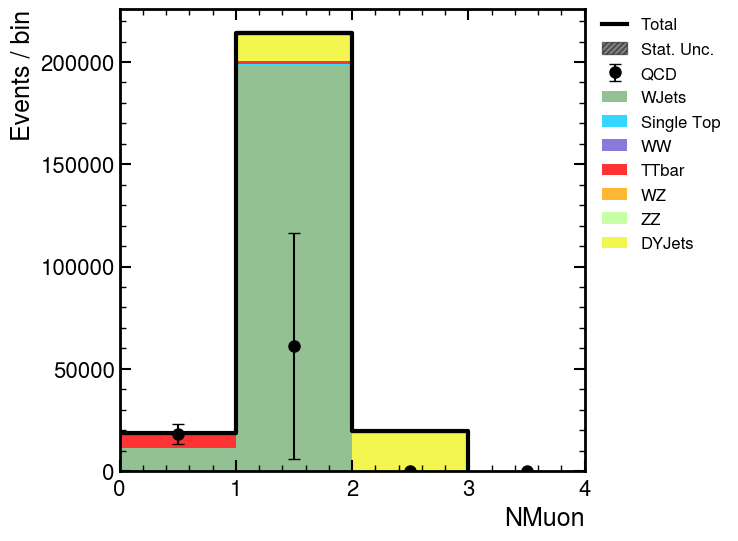

In [5]:
makePlot(dfs, var='NMuon', xmin = 0, xmax = 4, step_size = 1, ylog = False, saveFig = False, printOut = False, plot_ratio = False)